In [33]:
"""
in terminal
# jupyter nbconvert --to script realization2.ipynb
"""

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
# from scipy.interpolate import interp2d, bisplev
from scipy.interpolate import RectBivariateSpline, bisplrep, bisplev, griddata
import glob
import os
import re
from scipy.optimize import curve_fit
import sys
# from Definitions import *
import pickle




## read files

In [34]:

all_keys = ["d", "tcs", "Lxavg", "dLx", "Favg", "dF",
                 "eps", "EL_orb", "ER_orb", "V_acs", "Bhs", "ratioL", "ratioR", "source"]

# Subset you now care about
keys = ['d', 'tcs', 'Lxavg', 'dLx', 'Favg', 'dF', 'eps', 'Bhs',"EL_orb", "ER_orb", "V_acs", "ratioL", "ratioR"]

# --- Load npy arrays ---
cov_matrix_raw_1e10 = np.load('cov_matrix_raw_1e10.npy', allow_pickle=True)
cov_matrix_raw_5e9 = np.load('cov_matrix_raw_5e9.npy', allow_pickle=True)

# --- Convert to DataFrames with original full columns ---
cov_matrix_raw_1e10        = pd.DataFrame(cov_matrix_raw_1e10,        columns=all_keys[:cov_matrix_raw_1e10.shape[1]])
cov_matrix_raw_5e9        = pd.DataFrame(cov_matrix_raw_5e9,        columns=all_keys[:cov_matrix_raw_5e9.shape[1]])


# --- Now keep only the columns you want (intersect to be safe) ---
keep_cols = [c for c in keys if c in cov_matrix_raw_1e10.columns]

cov_matrix_raw_1e10 = cov_matrix_raw_1e10[keep_cols]
cov_matrix_raw_5e9 = cov_matrix_raw_5e9[keep_cols]

# Convert all columns in both DataFrames to float, coercing invalid values to NaN
cov_matrix_raw_1e10 = cov_matrix_raw_1e10.apply(pd.to_numeric, errors='coerce').astype(float)
cov_matrix_raw_5e9  = cov_matrix_raw_5e9.apply(pd.to_numeric, errors='coerce').astype(float)


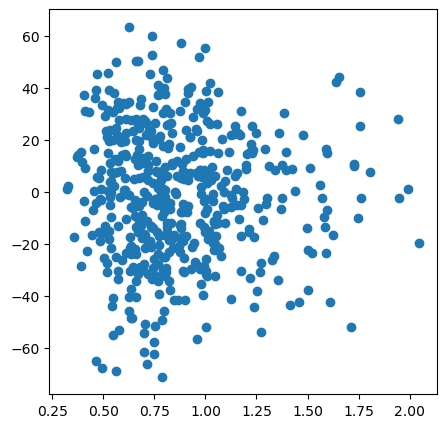

In [35]:
plt.figure(figsize=(5, 5))
plt.plot(cov_matrix_raw_1e10['Bhs']*1e3, cov_matrix_raw_1e10['V_acs']*1e3, 'o', label='Artificial')

### definitions

In [36]:
def binned_plot2(data, bin_edges=None, color="C0", label=None):
    if bin_edges is None:
        raise ValueError("You must provide fixed bin_edges.")

    # Compute bin centers
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    # Compute histogram
    counts, _ = np.histogram(data, bins=bin_edges)

    # Plot
    plt.bar(
        bin_centers,
        counts,
        width=(bin_edges[1] - bin_edges[0]),
        color=color,
        edgecolor='black',
        alpha=0.7,
        linewidth=0.5,   # <- thinner by default
        label=label
    )


from matplotlib.gridspec import GridSpecFromSubplotSpec
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def plot_acceptance_inside_axes3(
    ax_container,              # this is axes[3] from prepare_plot(...)
    x_V,                       # detuning correction; treated in mV for plotting/masking (matches your other function)
    y_tc_u_eV,                 # tunnel coupling in μeV (1D)
    orbL_meV, orbR_meV,        # orbital energies (1D)
    bhs,                       # color-by (barrier height)
    x_thresh_V=20.0,           # NOTE: interpreted as ±(mV), name kept to avoid breaking callers
    y_thresh_u_eV=10.0,        # ≥10 μeV
    ymax_thresh_u_eV=250.0,
    orb_thresh_meV=1.0,        # ≥1 meV each dot
    bhs_log=False,
    cmap="viridis",
    # Optional fixed colorbar limits: set to None to auto-scale
    cb_min=None,
    cb_max=None,
):
  
  
    def to_numeric_array(a):
        return np.array(pd.to_numeric(a, errors='coerce'), dtype=float)

    orbL_meV = to_numeric_array(orbL_meV)
    orbR_meV = to_numeric_array(orbR_meV)
    bhs = to_numeric_array(bhs)
    x_V = to_numeric_array(x_V)
    y_tc_u_eV = to_numeric_array(y_tc_u_eV)
  
  
  
  
  
  
  
  
  
  
    # --- stash figure & subplotspec BEFORE removing the container axis ---
    fig = ax_container.figure
    subsp = ax_container.get_subplotspec()
    ax_container.remove()

    # --- nested GridSpec inside axes[3] slot ---
    gs_inner = GridSpecFromSubplotSpec(
        4, 4, subplot_spec=subsp,
        height_ratios=[1.0, 0.05, 4.0, 0.3],
        width_ratios=[4.8, 0.06, 0.9, 0.04],
        wspace=0.1,
        hspace=0.1
    )
    ax_main  = fig.add_subplot(gs_inner[2, 0])
    ax_histx = fig.add_subplot(gs_inner[0, 0], sharex=ax_main)
    ax_histy = fig.add_subplot(gs_inner[2, 2], sharey=ax_main)

    # ---------- Data & masks (x treated in mV) ----------
    x_mV  = np.asarray(x_V)     # keep as-is (mV), matching your accepted function
    y     = np.asarray(y_tc_u_eV)
    orbL  = np.asarray(orbL_meV)
    orbR  = np.asarray(orbR_meV)
    cvals = np.asarray(bhs)

    base_mask = (
        np.isfinite(x_mV) & np.isfinite(y) &
        np.isfinite(orbL) & np.isfinite(orbR) &
        np.isfinite(cvals)
    )
    mask_accept = (
        base_mask &
        (np.abs(x_mV) <= x_thresh_V) &
        (y >= y_thresh_u_eV) & (y <= ymax_thresh_u_eV) &
        (orbL >= orb_thresh_meV) & (orbR >= orb_thresh_meV)
    )
    mask_reject = base_mask & (~mask_accept)

    # ---------- Axis limits ----------
    if np.any(base_mask):
        xmin = min(np.nanmin(x_mV[base_mask]), -x_thresh_V)
        xmax = max(np.nanmax(x_mV[base_mask]),  x_thresh_V)
        ymin = 0.0
        ymax = max(np.nanmax(y[base_mask]), y_thresh_u_eV * 1.25)
    else:
        xmin, xmax = -x_thresh_V, x_thresh_V
        ymin, ymax = 0.0, y_thresh_u_eV * 1.5

    xr = xmax - xmin
    xmin -= 0.001 * xr
    xmax += 0.001 * xr

    yr = ymax - ymin
    ymin = max(0.0, ymin - 0.05 * yr)
    ymax += 0.05 * yr

    ax_main.set_xlim(xmin, xmax)
    ax_main.set_ylim(ymin, ymax)

    # ----- X ticks/labels in mV -----
    xticks = np.arange(np.floor(xmin/40)*40, np.ceil(xmax/40)*40 + 1e-9, 40)
    ax_main.set_xticks(xticks)
    ax_main.set_xlabel(r"Detuning correction $\Delta V_{LR}$ (mV)")

    # ---------- Scatter ----------
    ax_main.scatter(x_mV[mask_reject], y[mask_reject], s=10, alpha=0.25,
                    edgecolor="none", color="0.6")

    if bhs_log:
        finite_pos = base_mask & (cvals > 0)
        if np.any(finite_pos):
            vmin = np.nanmin(cvals[finite_pos])
            vmax = np.nanmax(cvals[base_mask]) if np.any(base_mask) else vmin
            norm = LogNorm(vmin=vmin, vmax=vmax)
        else:
            # fallback to linear if no positive values
            vmin = np.nanmin(cvals[base_mask]) if np.any(base_mask) else 0.0
            vmax = np.nanmax(cvals[base_mask]) if np.any(base_mask) else 1.0
            norm = Normalize(vmin=vmin, vmax=vmax)
    else:
        vmin = np.nanmin(cvals[base_mask]) if np.any(base_mask) else 0.0
        vmax = np.nanmax(cvals[base_mask]) if np.any(base_mask) else 1.0
        norm = Normalize(vmin=vmin, vmax=vmax)

    cmap_obj = plt.cm.get_cmap(cmap, 10)
    sc = ax_main.scatter(x_mV[mask_accept], y[mask_accept], s=10, alpha=0.99,
                         c=cvals[mask_accept], cmap=cmap_obj, norm=norm,
                         linewidths=0.2, edgecolors="black")

    # Optional fixed colorbar limits
    if cb_min is not None or cb_max is not None:
        lo = vmin if cb_min is None else cb_min
        hi = vmax if cb_max is None else cb_max
        if bhs_log and lo <= 0:
            lo = max(lo, np.nextafter(0, 1))  # ensure >0 for LogNorm
        sc.set_clim(lo, hi)




    # --- Horizontal colorbar inside the main panel ---
    fig.canvas.draw()
    ax_main.set_anchor("N")
    cax = ax_main.inset_axes([0.05, 0.90, 0.30, 0.03])
    cb = fig.colorbar(sc, cax=cax, orientation="horizontal")
    cb.set_label(r"$h_B$ (meV)")

    # ---------- Success box (in mV × μeV) ----------
    rect_width  = 2 * x_thresh_V
    rect_height = max(0.0, ymax_thresh_u_eV - y_thresh_u_eV)
    ax_main.add_patch(mpl.patches.Rectangle(
        (-x_thresh_V, y_thresh_u_eV), rect_width, rect_height,
        facecolor="none", edgecolor="black", linewidth=1.2
    ))
    ax_main.add_patch(mpl.patches.Rectangle(
        (-x_thresh_V, y_thresh_u_eV), rect_width, rect_height,
        facecolor="gray", alpha=0.08, edgecolor="none"
    ))
    ax_main.axvline(-x_thresh_V, linestyle="--", linewidth=1.0, color="black")
    ax_main.axvline(+x_thresh_V, linestyle="--", linewidth=1.0, color="black")
    ax_main.axhline(y_thresh_u_eV, linestyle="--", linewidth=1.0, color="black")

    # ---------- Labels/grid ----------
    ax_main.set_ylabel(r"Tunnel coupling $t_c$ ($\mu$eV)")
    ax_main.grid(True, which="major", alpha=0.25)
    ax_main.minorticks_on()

    # ---------- Marginal histograms that ADD UP ----------
    bins_x = np.linspace(xmin, xmax, 50)
    bins_y = np.linspace(ymin, ymax, 50)

    N_total = np.count_nonzero(base_mask) or 1  # avoid /0
    w_rej = np.ones(np.count_nonzero(mask_reject)) / N_total
    w_acc = np.ones(np.count_nonzero(mask_accept)) / N_total
    w_all = np.ones(np.count_nonzero(base_mask))  / N_total

    ax_histx.hist(x_mV[mask_reject], bins=bins_x, weights=w_rej, alpha=0.35, density=False, color="0.6")
    ax_histx.hist(x_mV[mask_accept], bins=bins_x, weights=w_acc, alpha=0.9,  density=False, color="0.2")
    ax_histx.hist(x_mV[base_mask],   bins=bins_x, weights=w_all, histtype="step",
                  density=False, linewidth=1.0, color="black")

    ax_histx.axvline(-x_thresh_V, linestyle="--", linewidth=1.0, color="black")
    ax_histx.axvline(+x_thresh_V, linestyle="--", linewidth=1.0, color="black")
    ax_histx.set_yticks([])
    ax_histx.grid(True, axis="x", alpha=0.2)
    ax_histx.tick_params(axis="x", labelbottom=False)

    ax_histy.hist(y[mask_reject], bins=bins_y, weights=w_rej, alpha=0.35, density=False,
                  orientation="horizontal", color="0.6")
    ax_histy.hist(y[mask_accept], bins=bins_y, weights=w_acc, alpha=0.9, density=False,
                  orientation="horizontal", color="0.2")
    ax_histy.hist(y[base_mask],   bins=bins_y, weights=w_all, histtype="step", density=False,
                  orientation="horizontal", linewidth=1.0, color="black")

    ax_histy.axhline(y_thresh_u_eV, linestyle="--", linewidth=1.0, color="black")
    ax_histy.set_xticks([])
    ax_histy.grid(True, axis="y", alpha=0.2)
    ax_histy.tick_params(axis="y", labelleft=False)

    # ---------- Yield ----------
    denom = np.count_nonzero(base_mask)
    yld = 100.0 * (np.count_nonzero(mask_accept) / denom) if denom else 0.0
    return (ax_main, ax_histx, ax_histy), yld

import matplotlib.pyplot as plt

def prepare_plot(figsize=(7, 3), hspace=0.2):
    fig = plt.figure(figsize=figsize)
    # Use height_ratios since it's a 2x1 grid (2 rows, 1 column)
    gs = fig.add_gridspec(nrows=2, ncols=1, hspace=hspace, height_ratios=(1, 1))
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, 0])
    return fig, (ax1, ax2)

## plot Fig. 2

C:\Users\lcyw\AppData\Local\Temp\ipykernel_17312\599825746.py:151: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_obj = plt.cm.get_cmap(cmap, 10)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Yield = 71.8%
Yield = 45.8%


Text(-0.2, 1.2, 'b)')

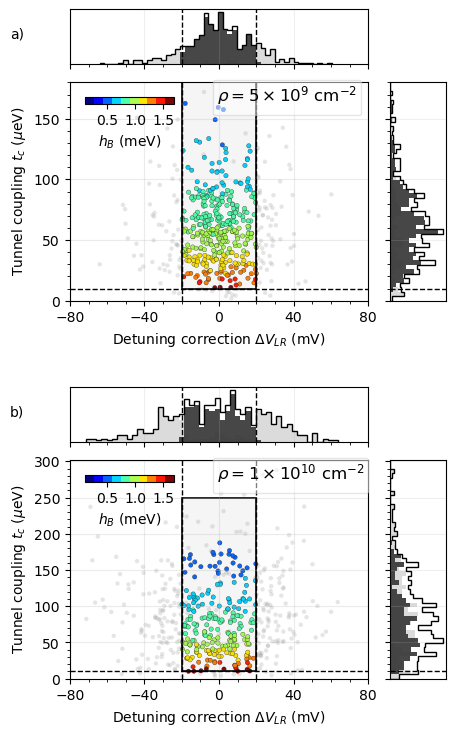

In [37]:
fig, (ax1, ax2) = prepare_plot(figsize=(5, 9))

labels = [
    r"$\rho = 5 \times 10^{9}$ cm$^{-2}$",
    r"$\rho = 1 \times 10^{10} $ cm$^{-2}$"
]


(ax_main, ax_histx, ax_histy), yld = plot_acceptance_inside_axes3(
    ax1,
    x_V=cov_matrix_raw_5e9["V_acs"]*1e3,  # in mV
    y_tc_u_eV=cov_matrix_raw_5e9["tcs"],   # ueV
    orbL_meV=cov_matrix_raw_5e9["EL_orb"]*1e3,  # meV
    orbR_meV=cov_matrix_raw_5e9["ER_orb"]*1e3,   # meV
    bhs=cov_matrix_raw_5e9["Bhs"]*1e3,    # meV
    x_thresh_V=20,         # ±20 mV (IN VOLTS)
    y_thresh_u_eV=10.0,
    orb_thresh_meV=1.0,
    bhs_log=False,
    cmap="jet",
    cb_min=0.1,             # keep your tested cmap
    cb_max=1.7
)
print(f"Yield = {yld:.1f}%")

# Top histogram: keep xticks but hide labels only on this axes
ax_histx.tick_params(axis="x", labelbottom=False)

# Right histogram: keep yticks but hide labels only on this axes
ax_histy.tick_params(axis="y", labelleft=False)



key = "rho_5e9"
ax_main.legend(
    title=rf"{labels[0]}",
    title_fontsize=12.,
    loc=(0.48, 0.85),
    ncol=2,
    frameon=True,
    fontsize=6.5,
    framealpha=0.5
)


""""""

(ax_main2, ax_histx, ax_histy), yld = plot_acceptance_inside_axes3(
    ax2,
    x_V=cov_matrix_raw_1e10["V_acs"]*1e3,  # in mV
    y_tc_u_eV=cov_matrix_raw_1e10["tcs"],   # ueV
    orbL_meV=cov_matrix_raw_1e10["EL_orb"]*1e3,  # meV
    orbR_meV=cov_matrix_raw_1e10["ER_orb"]*1e3,   # meV
    bhs=cov_matrix_raw_1e10["Bhs"]*1e3,    # meV
    x_thresh_V=20,         # ±20 mV (IN VOLTS)
    y_thresh_u_eV=10.0,
    orb_thresh_meV=1.0,
    bhs_log=False,
    cmap="jet",
    cb_min=0.1,             # keep your tested cmap
    cb_max=1.7
)
print(f"Yield = {yld:.1f}%")

# Top histogram: keep xticks but hide labels only on this axes
ax_histx.tick_params(axis="x", labelbottom=False)

# Right histogram: keep yticks but hide labels only on this axes
ax_histy.tick_params(axis="y", labelleft=False)




key = "rho_1e10"
ax_main2.legend(
    title=rf"{labels[1]}",
    title_fontsize=12.,
    loc=(0.48, 0.85),
    ncol=2,
    frameon=True,
    fontsize=6.5,
    framealpha=0.5
)



ax_main.text(-0.2, 1.2, fr"a)", transform=ax_main.transAxes)
ax_main2.text(-0.2, 1.2, fr"b)", transform=ax_main2.transAxes)








## Fig 3

In [38]:
from matplotlib.ticker import MaxNLocator, LinearLocator
from scipy.stats import gaussian_kde
import numpy as np
import matplotlib.pyplot as plt

def hist_plots(
    ax,
    key,
    scale=1.0,
    *,
    data=cov_matrix_raw_1e10,
    data2=cov_matrix_raw_5e9,
    bins=18,
    range_=None,
    pad_frac=0.05,
    colors=("C0", "C1"),
    labels=(r"$\rho = 1 \times 10^{10}$ (cm$^{-2}$)", r"$\rho = 5 \times 10^{9}$ (cm$^{-2}$)"),
    kde=True,
    kde_points=600,
    bw_scale=1.3,
    shaded=None,
    shaded_kwargs=None,
    xlabel=None,
    ylabel="count",
    legend=True,
    xticks_n=None,
    yticks_n=None,
    tick_mode="max",
    # NEW:
    preserve_position=True,   # keep manual shifts
    adjust_subplots=False,    # avoid global layout changes
):
    # --- preserve the current position (important for your manual shift) ---
    _pos = ax.get_position().frozen() if preserve_position else None

    plt.sca(ax)
    if adjust_subplots:
        try:
            plt.subplots_adjust(left=0.18, bottom=0.16, right=0.97, top=0.94)
        except Exception:
            pass

    # ---- pull + scale + clean ----
    x1 = np.asarray(data[key], float) * scale
    x2 = np.asarray(data2[key], float) * scale
    x1 = x1[np.isfinite(x1)]
    x2 = x2[np.isfinite(x2)]

    print(f"averages: {key}", np.average(x1), np.average(x2))
    # ---- binning ----
    if range_ is None:
        if x1.size == 0 and x2.size == 0:
            raise ValueError(f"No finite data for key '{key}'.")
        vmin = np.nanmin([x1.min() if x1.size else np.inf, x2.min() if x2.size else np.inf])
        vmax = np.nanmax([x1.max() if x1.size else -np.inf, x2.max() if x2.size else -np.inf])
        if vmin == vmax:
            delta = 1.0 if vmin == 0 else abs(vmin) * 0.05
            vmin, vmax = vmin - delta, vmax + delta
        span = vmax - vmin
        vmin -= pad_frac * span
        vmax += pad_frac * span
    else:
        vmin, vmax = range_

    bin_edges = np.linspace(vmin, vmax, bins)
    bin_width = np.diff(bin_edges)[0]

    # ---- bars ----
    artists = {"bars": []}
    used_binned_plot2 = "binned_plot2" in globals()
    if used_binned_plot2:
        artists["bars"].append(binned_plot2(x1, bin_edges=bin_edges, color=colors[0], label=labels[0]))
        artists["bars"].append(binned_plot2(x2, bin_edges=bin_edges, color=colors[1], label=labels[1]))

    else:
        n1, _, p1 = ax.hist(x1, bins=bin_edges, histtype="stepfilled", alpha=0.4, color=colors[0], label=labels[0])
        n2, _, p2 = ax.hist(x2, bins=bin_edges, histtype="stepfilled", alpha=0.4, color=colors[1], label=labels[1])
        artists["bars"].extend([p1, p2])

    # ---- shaded ----
    if shaded is not None:
        skw = dict(color="gray", alpha=0.1, label="_nolegend_")
        if shaded_kwargs: skw.update(shaded_kwargs)
        ax.axvspan(shaded[0], shaded[1], **skw)

    # ---- KDE ----
    import matplotlib.colors as mcolors
    def darken(color, factor=0.8):
        r, g, b = mcolors.to_rgb(color)
        return (r*factor, g*factor, b*factor)

    C0_darker = darken("C0", 0.9)  # ~= (0.097, 0.373, 0.565) -> #195F90
    C1_darker = darken("C1", 0.9)  # ~= (0.800, 0.398, 0.044) -> #CC660B

    artists["kde"] = []
    if kde:
        xx = np.linspace(bin_edges[0], bin_edges[-1], kde_points)

        def _safe_kde(x):
            if x.size < 2 or np.allclose(x, x[0]): return None
            return gaussian_kde(x, bw_method=lambda s: bw_scale * s.scotts_factor())

        kde1, kde2 = _safe_kde(x1), _safe_kde(x2)
        if kde1 is not None:
            y1 = kde1(xx) * x1.size * bin_width
            # artists["kde"].append(ax.plot(xx, y1, color=colors[0], lw=1.5)[0])
            artists["kde"].append(ax.plot(xx, y1, color=C0_darker, lw=1.5)[0])

        if kde2 is not None:
            y2 = kde2(xx) * x2.size * bin_width
            # artists["kde"].append(ax.plot(xx, y2, color=colors[1], lw=1.5)[0])
            artists["kde"].append(ax.plot(xx, y2, color=C1_darker, lw=1.5)[0])

    # ---- labels / legend ----
    if xlabel is None: xlabel = f"{key}"
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if legend: ax.legend()

    # ---- tick control ----
    if tick_mode not in {"max", "linear"}:
        raise ValueError("tick_mode must be 'max' or 'linear'.")
    if xticks_n is not None:
        ax.xaxis.set_major_locator(MaxNLocator(nbins=int(xticks_n)) if tick_mode=="max"
                                   else LinearLocator(numticks=int(xticks_n)))
    if yticks_n is not None:
        ax.yaxis.set_major_locator(MaxNLocator(nbins=int(yticks_n)) if tick_mode=="max"
                                   else LinearLocator(numticks=int(yticks_n)))

    # --- restore the original position (keeps your manual shift) ---
    if _pos is not None:
        ax.set_position(_pos)

    return {
        "bin_edges": bin_edges,
        "bin_width": bin_width,
        "used_binned_plot2": used_binned_plot2,
        "artists": artists,
    }

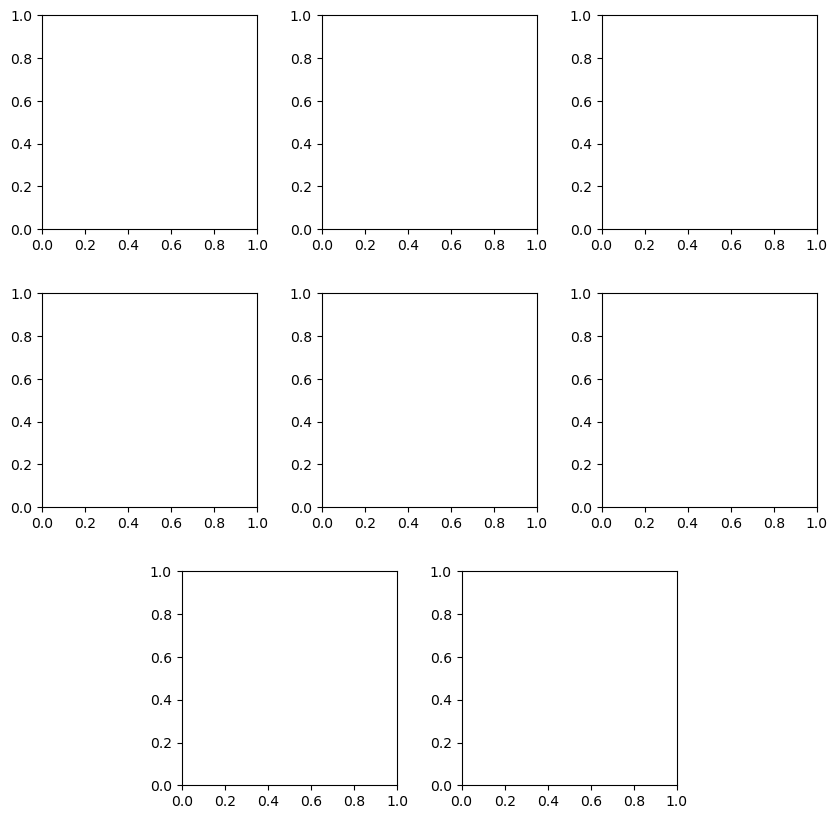

In [39]:
import numpy as np
import matplotlib.pyplot as plt

def prepare_plot(
    nrows=2,
    ncols=3,
    figsize=(7, 3),
    wspace=0.3,
    hspace=None,
    width_ratios=None,   # length must equal ncols if provided
    height_ratios=None,  # length must equal nrows if provided
    sharex=False,
    sharey=False,
    return_style="auto", # 'auto' | 'tuple2' | 'flat' | 'matrix'
):
    """
    Create a figure + GridSpec-based subplots with dynamic rows/cols.

    Returns:
      - if return_style='tuple2' (or 'auto' with exactly 2 axes): (fig, (ax1, ax2))
      - if return_style='flat': (fig, axes_flat_1d)
      - if return_style='matrix' (or 'auto' with != 2 axes): (fig, axes_2d_array)
    """
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(
        nrows=nrows,
        ncols=ncols,
        wspace=wspace,
        hspace=hspace,
        width_ratios=width_ratios,
        height_ratios=height_ratios,
    )

    # Build axes grid, optionally sharing x/y where requested
    axes = np.empty((nrows, ncols), dtype=object)
    for r in range(nrows):
        for c in range(ncols):
            kw = {}
            if sharex and r > 0:
                kw["sharex"] = axes[0, c]
            if sharey and c > 0:
                kw["sharey"] = axes[r, 0]
            axes[r, c] = fig.add_subplot(gs[r, c], **kw)

    # Decide return style
    if return_style == "tuple2" or (return_style == "auto" and nrows * ncols == 2):
        ax1, ax2 = axes.flat[0], axes.flat[1]
        return fig, (ax1, ax2)
    elif return_style == "flat":
        return fig, axes.flatten()
    else:  # 'matrix' or 'auto' (not 2 axes)
        return fig, axes

# --- Examples ---

# 1) Backward-compatible: two-axes layout like your original
# fig, (ax1, ax2) = prepare_plot(nrows=1, ncols=2, figsize=(7, 3), wspace=0.3, return_style="tuple2")

# 2) A 2x3 grid returning a 2D array of axes
fig, axs = prepare_plot(nrows=3, ncols=3, figsize=(10, 10), wspace=0.3, hspace=0.3, return_style="matrix")

# Remove the center axis to "put the leftover part" in the middle
r_mid, c_mid = 2 , 1
fig.delaxes(axs[r_mid, c_mid])   # delete the center subplot
axs[r_mid, c_mid] = None         # keep matrix shape; mark the hole

# (Optional) convenience list of the 8 axes
axes8 = [ax for ax in axs.flat if ax is not None]


# You already did:
# fig, axs = prepare_plot(nrows=3, ncols=3, figsize=(10, 10), wspace=0.1, hspace=0.1, return_style="matrix")
# fig.delaxes(axs[2,1]); axs[2,1] = None   # middle removed

def _center_bottom_pair(fig, axs, row=2):
    # Measure column centers from any existing row (use row 0 which is fully populated)
    def center(ax):
        bb = ax.get_position()
        return 0.5 * (bb.x0 + bb.x1), (bb.x1 - bb.x0)

    c0, w0 = center(axs[0,0])
    c1, w1 = center(axs[0,1])
    c2, w2 = center(axs[0,2])

    # Target centers: halfway between (0 & 1) and (1 & 2)
    target_left_center  = 0.5 * (c0 + c1)
    target_right_center = 0.5 * (c1 + c2)

    # Shift helpers
    def shift_to_center(ax, target_center):
        bb = ax.get_position()
        width = bb.x1 - bb.x0
        dx = target_center - 0.5 * (bb.x0 + bb.x1)
        new_x0 = bb.x0 + dx
        new_x1 = bb.x1 + dx
        ax.set_position([new_x0, bb.y0, width, bb.y1 - bb.y0])

    # Move the two bottom axes inward
    if axs[row, 0] is not None:
        shift_to_center(axs[row, 0], target_left_center)
    if axs[row, 2] is not None:
        shift_to_center(axs[row, 2], target_right_center)

# Call it:
_center_bottom_pair(fig, axs)

averages: Bhs 0.8666948741758969 0.958803508857754
averages: tcs 87.0136880750483 60.95489646930585
averages: eps -0.08678751005811051 0.01531591947370584
averages: d 90.54237715712199 94.67175109207861
averages: Lxavg 23.81361426895356 23.601024946484976
averages: dLx 0.047974635561420606 0.002053616760016389
averages: Favg 5.17296965680137 5.180099214705602
averages: dF -0.0004997609641968346 0.0001432924758028129
averages: ratioL 1.0656924810966548 1.0728162303133741


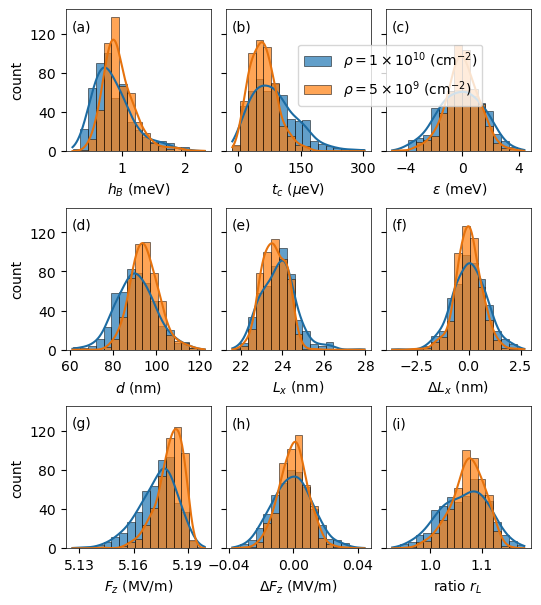

In [40]:
"""choice 1"""
# fig, axs = prepare_plot(nrows=3, ncols=3, figsize=(10, 10), wspace=0.3, hspace=0.3, return_style="matrix")

# # Remove the center axis to "put the leftover part" in the middle
# r_mid, c_mid = 2 , 2
# fig.delaxes(axs[r_mid, c_mid])   # delete the center subplot
# axs[r_mid, c_mid] = None         # keep matrix shape; mark the hole


"""choice 2"""

fig, axs = prepare_plot(nrows=3, ncols=3, figsize=(6, 7.), wspace=0.1, hspace=0.4, return_style="matrix")


# Remove the center axis to "put the leftover part" in the middle
# r_mid, c_mid = 2 , 1
# fig.delaxes(axs[r_mid, c_mid])   # delete the center subplot
# axs[r_mid, c_mid] = None         # keep matrix shape; mark the hole

# (Optional) convenience list of the 8 axes
# axes8 = [ax for ax in axs.flat if ax is not None]


# You already did:
# fig, axs = prepare_plot(nrows=3, ncols=3, figsize=(10, 10), wspace=0.1, hspace=0.1, return_style="matrix")
# fig.delaxes(axs[2,1]); axs[2,1] = None   # middle removed

def _center_bottom_pair(fig, axs, row=2):
    # Measure column centers from any existing row (use row 0 which is fully populated)
    def center(ax):
        bb = ax.get_position()
        return 0.5 * (bb.x0 + bb.x1), (bb.x1 - bb.x0)

    c0, w0 = center(axs[0,0])
    c1, w1 = center(axs[0,1])
    c2, w2 = center(axs[0,2])

    # Target centers: halfway between (0 & 1) and (1 & 2)
    target_left_center  = 0.5 * (c0 + c1)
    target_right_center = 0.5 * (c1 + c2)

    # Shift helpers
    def shift_to_center(ax, target_center):
        bb = ax.get_position()
        width = bb.x1 - bb.x0
        dx = target_center - 0.5 * (bb.x0 + bb.x1)
        new_x0 = bb.x0 + dx
        new_x1 = bb.x1 + dx
        ax.set_position([new_x0, bb.y0, width, bb.y1 - bb.y0])

    # Move the two bottom axes inward
    if axs[row, 0] is not None:
        shift_to_center(axs[row, 0], target_left_center)
    if axs[row, 2] is not None:
        shift_to_center(axs[row, 2], target_right_center)

# Call it:
# _center_bottom_pair(fig, axs)

# hist_plot_tc(axs[0,0])
# hist_plot_hb(axs[0,1])

out = hist_plots(
    axs[0,0],
    key="Bhs",
    scale=1e3,
    bins=18,
    xticks_n=2, yticks_n=4,  # <- control ticks
    tick_mode="max",         # or "linear" for evenly spaced ticks
    xlabel=r"$h_B$ (meV)"
)


out = hist_plots(
    axs[0,1],          # any axis from your 3x3 grid (with center removed)
    key="tcs",
    scale=1e0,         # eV -> meV
    shaded=None, # optional: shade h_B < 0.5 meV
    bins=18,
    xticks_n=3, yticks_n=4,  # <- control ticks
    tick_mode="max",         # or "linear" for evenly spaced ticks
    xlabel=r"$t_{c}$ ($\mu$eV)"
)

out = hist_plots(
    axs[0,2],          # any axis from your 3x3 grid (with center removed)
    key="eps",
    scale=1e0,         # eV -> meV
    shaded=None, # optional: shade h_B < 0.5 meV
    bins=18,
    xticks_n=3, yticks_n=4,  # <- control ticks
    tick_mode="max",         # or "linear" for evenly spaced ticks
    xlabel=r" $\epsilon$ (meV)"
)


out = hist_plots(
    axs[1,0],          # any axis from your 3x3 grid (with center removed)
    key="d",
    scale=1e0,         # eV -> meV
    shaded=None, # optional: shade h_B < 0.5 meV
    bins=18,
    xticks_n=4, yticks_n=4,  # <- control ticks
    tick_mode="max",         # or "linear" for evenly spaced ticks
    xlabel=r"$d$ (nm)"
)

out = hist_plots(
    axs[1,1],          # any axis from your 3x3 grid (with center removed)
    key="Lxavg",
    scale=1e0,         # eV -> meV
    shaded=None, # optional: shade h_B < 0.5 meV
    bins=18,
    xticks_n=4, yticks_n=4,  # <- control ticks
    tick_mode="max",         # or "linear" for evenly spaced ticks
    xlabel=r"$ L_{x}  $ (nm)"
)

out = hist_plots(
    axs[1,2],          # any axis from your 3x3 grid (with center removed)
    key="dLx",
    scale=1e0,         # eV -> meV
    shaded=None, # optional: shade h_B < 0.5 meV
    bins=18,
    xticks_n=3, yticks_n=4,  # <- control ticks
    tick_mode="max",         # or "linear" for evenly spaced ticks
    xlabel=r"$\Delta L_{x} $ (nm)"
)

out = hist_plots(
    axs[2,0],          # any axis from your 3x3 grid (with center removed)
    key="Favg",
    scale=1e0,         # eV -> meV
    shaded=None, # optional: shade h_B < 0.5 meV
    bins=18,
    xticks_n=3, yticks_n=4,  # <- control ticks
    tick_mode="max",         # or "linear" for evenly spaced ticks
    xlabel=r"$  F_{z} $ (MV/m)"
)

out = hist_plots(
    axs[2,1],          # any axis from your 3x3 grid (with center removed)
    key="dF",
    scale=1e0,         # eV -> meV
    shaded=None, # optional: shade h_B < 0.5 meV
    bins=18,
    xticks_n=3, yticks_n=4,  # <- control ticks
    tick_mode="max",         # or "linear" for evenly spaced ticks
    xlabel=r"$\Delta F_{z} $ (MV/m)"
)


out = hist_plots(
    axs[2,2],          # any axis from your 3x3 grid (with center removed)
    key="ratioL",
    scale=1e0,         # eV -> meV
    shaded=None, # optional: shade h_B < 0.5 meV
    bins=18,
    xticks_n=3, yticks_n=4,  # <- control ticks
    tick_mode="max",         # or "linear" for evenly spaced ticks
    xlabel=r"ratio $r_L $ "
)



import numpy as np
import matplotlib.pyplot as plt

def style_all_axes(axs, ylim=(0, 180), clear_ylabel=True, hide_y_on_nonfirstcol=True):
    """
    axs: 2D array (or 1D list) of axes; None entries are ignored.
    ylim: tuple -> y-limits applied to all axes.
    clear_ylabel: True -> remove ylabel on all axes.
    hide_y_on_nonfirstcol: True -> hide y tick *labels* on non-first columns.
    """
    axs_arr = np.asarray(axs, dtype=object)
    # If it's 1D, treat as a single column
    is_2d = axs_arr.ndim == 2
    for idx, ax in np.ndenumerate(axs_arr):
        if ax is None:
            continue

        # set common y-limit
        ax.set_ylim(*ylim)

        # clear ylabel if requested
        if clear_ylabel:
            ax.set_ylabel("")

        # hide y tick labels on non-first columns (without raising formatter warnings)
        if hide_y_on_nonfirstcol:
            in_first_col = (idx[1] == 0) if is_2d else True
            if not in_first_col:
                ax.tick_params(labelleft=False)  # hides labels safely

# ---- use it ----
style_all_axes(axs, ylim=(0, 145), clear_ylabel=True, hide_y_on_nonfirstcol=True)


# style_all_axes(axs, ylim=(0, 250), clear_ylabel=True, hide_y_on_nonfirstcol=True)

selcted_axes = [axs[1,0], axs[1,1],axs[1,2], ]
style_all_axes(selcted_axes, ylim=(0, 145), clear_ylabel=True, hide_y_on_nonfirstcol=True)

# # ax2.set_yticks([])
# ax2.set_yticklabels([])
axs[0,0].set_ylabel("count")
axs[1,0].set_ylabel("count")
axs[2,0].set_ylabel("count")
axes_list = [ax for ax in axs.flat if ax is not None]

# ax1.set_ylim(0, 180)
# ax2.set_ylim(0, 180)
[sp.set_linewidth(0.5) for ax in axes_list for sp in ax.spines.values()]


# 1) remove ALL legends
for ax in [a for a in axs.flat if a is not None]:
    leg = ax.get_legend()
    if leg: leg.remove()

# 2) add ONE legend at a given subplot position [r, c]
r, c = 0, 2  # <-- choose where you want the legend
handles, labels, seen = [], [], set()
for ax in [a for a in axs.flat if a is not None]:
    h, l = ax.get_legend_handles_labels()
    for hh, ll in zip(h, l):
        if ll and not ll.startswith("_") and ll not in seen:
            handles.append(hh); labels.append(ll); seen.add(ll)

# axs[r, c].legend(handles, labels, loc="upper right")  # inside
# or outside to the right:
axs[r, c].legend(handles, labels, loc="upper left", bbox_to_anchor=(-0.65, 0.8))


labels = list("abcdefghi")
for i, ax in enumerate(axes_list):
    ax.text(0.04, 0.85, fr"({labels[i]})", transform=ax.transAxes)




## Fig 4

In [45]:
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kernel_density import KDEMultivariateConditional
import matplotlib.colors as mcolors

def plot_joint_conditional_density(
    ax,
    data,
    A_col="d", B_col="Bhs", C_col="tcs",
    A_scale=1e0, B_scale=1e3, C_scale=1e0, # Scaled sample data, so using 1.0
    c0_values=(10, 50, 200),  # Corrected variable name for clarity (was b0_values)
    bw_choice="normal_reference",
    n_grid=200, pad_frac=0.2,
    trim_tails=True, tail_alpha=1e-1,
    A_label=r"$d$ (nm)", B_label=r"${h_B}$ (meV)", C_label=r"$t_c$ ($\mu$eV)",
    A_sym=r"d", B_sym=r"h_B", C_sym=r"t_c",
    ylim=None,
    legend_title=r"$\rho = 1 \times 10^{10}$ cm$^{-2}$",
    show=False
):
    """
    Plot joint kernel conditional densities f(A,B|C=c0) on an existing Matplotlib Axes (ax).
    Returns (fig, ax).
    """
    # --- choose axes ---
    created_ax = ax is None
    if created_ax:
        fig, ax = plt.subplots(figsize=(6.2, 5.0))
    else:
        fig = ax.figure

    # --- data → units → clean ---
    A = np.asarray(data[A_col]) * A_scale
    B = np.asarray(data[B_col]) * B_scale
    C = np.asarray(data[C_col]) * C_scale
    m = np.isfinite(A) & np.isfinite(B) & np.isfinite(C)
    A, B, C = A[m].astype(float), B[m].astype(float), C[m].astype(float)

    # --- standardize (fit space) ---
    A_mu, A_sd = A.mean(), A.std(ddof=1)
    B_mu, B_sd = B.mean(), B.std(ddof=1)
    C_mu, C_sd = C.mean(), C.std(ddof=1)
    if A_sd <= 0 or B_sd <= 0 or C_sd <= 0:
        raise ValueError("Zero variance in A, B, or C; KDE undefined.")
    Az, Bz, Cz = (A - A_mu)/A_sd, (B - B_mu)/B_sd, (C - C_mu)/C_sd

    # --- conditional KDE in z-space ---
    # CORRECTION: To model p(A, B | C), A and B are the dependent variables (endog)
    # and C is the independent/conditional variable (exog).
    kde = KDEMultivariateConditional(
        endog=np.column_stack([Az, Bz]), exog=Cz,
        dep_type="cc", indep_type="c", bw=bw_choice
    )

    # --- grid (original units) ---
    A_L, B_L = A.max() - A.min(), B.max() - B.min()
    A_pad = pad_frac * A_L if A_L > 0 else 1.0
    B_pad = pad_frac * B_L if B_L > 0 else 1.0
    A_grid_pts = np.linspace(A.min() - A_pad, A.max() + A_pad, n_grid)
    B_grid_pts = np.linspace(B.min() - B_pad, B.max() + B_pad, n_grid)
    A_grid, B_grid = np.meshgrid(A_grid_pts, B_grid_pts)

    # CORRECTION: This function was rewritten to match the corrected KDE model.
    def f_cond(c0):
        # Standardize grid and conditional value
        Az_grid = (A_grid - A_mu) / A_sd
        Bz_grid = (B_grid - B_mu) / B_sd
        Cz_cond = (c0 - C_mu) / C_sd

        # endog_predict requires shape (n_points, 2) for (A,B) pairs
        endog_pred = np.column_stack([Az_grid.ravel(), Bz_grid.ravel()])
        # exog_predict requires shape (n_points,) for the C value
        exog_pred = np.full(Az_grid.size, Cz_cond)

        dens_z = kde.pdf(endog_predict=endog_pred, exog_predict=exog_pred)
        # Rescale density from z-space to original space
        dens = np.clip(dens_z / (A_sd * B_sd), 0.0, None)
        return dens.reshape(A_grid.shape)

    # --- plot conditionals ---
    cmaps = ['Blues', 'Greens', 'Oranges']
    colors = ['b','g', 'y']
    for i, c0 in enumerate(c0_values):
        y = f_cond(c0)
        if trim_tails:
            # Use NaN for values below threshold to prevent them from being plotted
            y[y < tail_alpha * y.max()] = np.nan

        # color = plt.cm.get_cmap(cmaps[i % len(cmaps)])(0.7)
        ax.contourf(A_grid, B_grid, y, levels=10, cmap=cmaps[i % len(cmaps)], alpha=0.7)
        
        # CORRECTION: The original ax.plot call would produce a garbage plot.
        # This creates an invisible line with the correct color and label for the legend.
        ax.plot([], [], lw=2.5, color=colors[i],
                label=rf"$P({A_sym}, {B_sym} \mid {C_sym}={int(c0)})$")

    # Set axis limits before drawing marginals
    if ylim is not None: ax.set_ylim(*ylim)
    
    # --- marginal f(A) ---
    # CORRECTION: The original marginal plot was incorrect. This version plots
    # the marginal density of A along the x-axis, scaled to fit within the y-limits.
    marginal_A_pdf = gaussian_kde(A)(A_grid_pts)
    ymin, ymax = ax.get_ylim()
    # Scale PDF to take up the bottom 20% of the y-axis for visualization
    marginal_A_scaled = ymin + (marginal_A_pdf / marginal_A_pdf.max()) * (ymax - ymin) * 0.2
    # ax.plot(A_grid_pts, marginal_A_scaled, ls="--", color='k', lw=1.2, label=rf"$P({A_sym})$")
    # ax.fill_between(A_grid_pts, ymin, marginal_A_scaled, color="k", alpha=0.1)


    ax.set_xlabel(A_label)
    ax.set_ylabel(B_label)
    ax.legend(title=legend_title, frameon=False, loc="upper left", fontsize=8, title_fontsize=12)

    if created_ax:
        fig.tight_layout()
        if show: plt.show()

    return fig, ax

In [46]:
import numpy as np
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt



# === Main Execution for both rhos ===
datasets = {
    "rho_1e10": cov_matrix_raw_1e10,   # ρ = 1 × 10^10 (cm^-2)
    "rho_5e9":  cov_matrix_raw_5e9   # ρ = 5 × 10^9  (cm^-2)
}


rho_labels = {
    "rho_1e10": r"$\rho = 1 \times 10^{10}$ (cm$^{-2}$)",
    "rho_5e9":  r"$\rho = 5 \times 10^{9}$ (cm$^{-2}$)"
}


# === Constants ===
hbar = 1.054571817e-34  # J·s
e = 1.602176634e-19     # C
me = 9.10938356e-31     # kg
mstar = 0.19 * me
prefactor = np.sqrt(2 * mstar) / hbar  # 1/(m·√J)

def predict_tc_fit(d_nm, Eb_meV, tc0_ueV, beta):
    """
    Vectorized prediction of tunnel coupling tc [μeV] using the fitted model.

    Parameters:
    - d_nm : float or array_like — barrier width(s) in nm
    - Eb_meV : float or array_like — barrier height(s) in meV
    - tc0_ueV : float — fitted tc0 in μeV
    - beta : float — fitted dimensionless exponent scaling factor

    Returns:
    - tc_fit : np.ndarray — predicted tunnel coupling(s) in μeV
    """
    # Constants
    hbar = 1.054571817e-34  # J·s
    e = 1.602176634e-19     # J
    me = 9.10938356e-31     # kg
    mstar = 0.19 * me
    prefactor = np.sqrt(2 * mstar) / hbar

    # Convert to arrays and broadcast shapes
    d_nm = np.asarray(d_nm)
    Eb_meV = np.asarray(Eb_meV)
    d_nm, Eb_meV = np.broadcast_arrays(d_nm, Eb_meV)

    # Convert to SI
    Eb_J = Eb_meV * 1e-3 * e
    d_m = d_nm * 1e-9

    # Compute and return
    exponent = -beta * prefactor * d_m * np.sqrt(Eb_J)
    return tc0_ueV * np.exp(exponent)


def fit_tc_model_fixed_beta(tc_raw, Eb_raw, d_raw, beta_fixed=0.5, p0_tc0=1000):
    # Model with fixed beta
    def tc_model_fixed(inputs, tc0):
        Eb_meV, d_nm = inputs
        Eb_J = Eb_meV * 1e-3 * e
        d_m = d_nm * 1e-9
        exponent = -beta_fixed * prefactor * d_m * np.sqrt(Eb_J)
        return tc0 * np.exp(exponent)

    # Fit tc0
    inputs = (Eb_raw, d_raw)
    popt, pcov = curve_fit(tc_model_fixed, inputs, tc_raw, p0=[p0_tc0])
    tc0_fit = popt[0]
    tc_fit = tc_model_fixed(inputs, tc0_fit)

    # Metrics
    rmse = np.sqrt(mean_squared_error(tc_raw, tc_fit))
    r2 = r2_score(tc_raw, tc_fit)
    perr = np.sqrt(np.diag(pcov))

    return tc0_fit, perr[0], tc_fit, rmse, r2


def get_tc0(key):


    # Prepare inputs for fitting
    tc_raw = np.array(datasets[key]["tcs"])       # μeV
    Eb_raw = np.array(datasets[key]["Bhs"]) * 1e3 # eV → meV
    d_raw  = np.array(datasets[key]["d"])         # nm

    # Fit model with beta = 0.5
    tc0_fit, tc0_err, tc_fit, rmse, r2 = fit_tc_model_fixed_beta(tc_raw, Eb_raw, d_raw, beta_fixed=0.5)

    # Report
    print(f"\nFitted tc0  = {tc0_fit:.3f} ± {tc0_err:.3f} μeV (with β = 0.5 fixed)")
    print(f"RMSE        = {rmse:.3f} μeV")
    print(f"R² Score    = {r2:.5f}")

    # Output comparison
    # print_comparison(tc_raw, tc_fit)
    # plot_fit(tc_raw, tc_fit)
    return tc0_fit

def plot_tc_fit(ax, key):

    # Prepare inputs for fitting
    tc_raw = np.array(datasets[key]["tcs"])       # μeV
    Eb_raw = np.array(datasets[key]["Bhs"]) * 1e3 # eV → meV
    d_raw  = np.array(datasets[key]["d"])         # nm
    
    tc0 = get_tc0(key)

    plt.sca(ax)
    plt.subplots_adjust(left=0.18, bottom=0.16, right=0.97, top=0.94)

    tc_fit = predict_tc_fit(d_raw, Eb_raw, tc0, 0.5)

    # --- shaded region for d < 80 ---
    ax.axvspan(50, 80, color="gray", alpha=0.1, label="_nolegend_")

    # --- raw experimental data ---
    plt.plot(d_raw, tc_raw, "o", color="orange", alpha=0.7,
             markersize=6, label='Data')

    # --- fit curve ---
    plt.plot(d_raw, tc_fit, ".", color="blue", alpha=0.6,
             markersize=3, label='fit')
    

    plt.xlabel(r'd (nm)')
    plt.ylabel(r'$t_c$ ($\mu$eV)')
    plt.legend(fontsize=16)

In [49]:
def prepare_plot(figsize, height_ratios=(1, 1, 1, 1)):
    fig = plt.figure(1, figsize=figsize)

    # 4 grid rows, 1 column; last axis spans rows 3–4
    gs = fig.add_gridspec(
        nrows=4, ncols=1,
        hspace=0.0,
        height_ratios=height_ratios
    )

    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
    ax3 = fig.add_subplot(gs[2:4, 0], sharex=ax1)

    # Panels 1 & 2: ONLY major tick marks at the TOP (no labels, no bottom ticks)
    for ax in ( ax1, ax2):
        ax.set_xlabel("")
        ax.xaxis.set_ticks_position("top")                  # move ticks to top spine
        ax.tick_params(axis="x", which="major",
                       top=True, bottom=False,
                       labeltop=False, labelbottom=False,
                       length=4)
        ax.tick_params(axis="x", which="minor",
                       top=False, bottom=False)             # ensure no minor ticks

    # ax3.xaxis.set_ticks_position("bottom")                  # move ticks to top spine
    ax3.tick_params(axis="x", which="major",
                       top=True, bottom=True,
                       labeltop=False, labelbottom=True,
                       length=4)
    ax1.tick_params(axis="x", which="major",
                       top=False, bottom=True,
                       labeltop=False, labelbottom=False,
                       length=4)
    
    return [ax1, ax2, ax3]

# axes = prepare_plot(figsize=(3.5, 6))



Fitted tc0  = 1246.998 ± 6.146 μeV (with β = 0.5 fixed)
RMSE        = 11.165 μeV
R² Score    = 0.95609

Fitted tc0  = 1322.064 ± 3.415 μeV (with β = 0.5 fixed)
RMSE        = 3.957 μeV
R² Score    = 0.98439


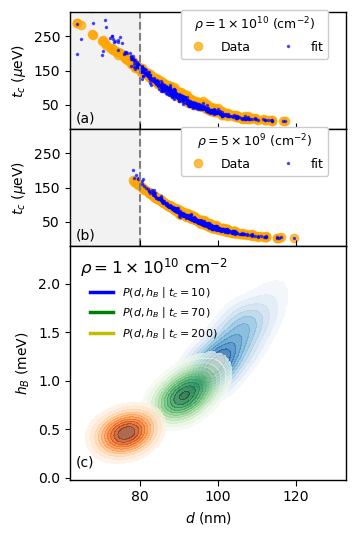

In [52]:
axes = prepare_plot(figsize=(3.5, 6))


key = "rho_1e10"   # or "rho_5e9"
plot_tc_fit(axes[0], key)
axes[0].tick_params(axis='x', labelbottom=False)  # hides tick label text, keeps tick marks

axes[0].set_xlim([62, 133])

axes[0].set_ylim([-20,320])
axes[0].set_yticks([50,150, 250])
axes[0].set_yticklabels([50,150, 250])


axes[0].axvline(x=80, color='grey', linestyle='--')
axes[0].legend(
    title=rf"{rho_labels[key]}",
    title_fontsize=9,   # <--- make title a bit larger
    loc=[0.4, 0.6],
    ncol=2,
    frameon=True,
    fontsize=9,
    framealpha=1
)


key = "rho_5e9"   # or "rho_5e9"
plot_tc_fit(axes[1], key)
# axes[1].set_xticks(np.linspace(70, 130, 5))
# axes[1].set_yticks(np.linspace(10, 320, 3))
axes[1].set_ylim([-20,320])

axes[1].set_yticks([50,150, 250])
axes[1].set_yticklabels([50,150, 250])

axes[1].axvline(x=80, color='grey', linestyle='--')
axes[1].sharex(axes[0])
axes[1].legend(
    title=rf"{rho_labels[key]}",
    title_fontsize=9,   # <--- make title a bit larger
    loc=[0.4, 0.6],
    ncol=2,
    frameon=True,
    fontsize=9,
    framealpha=1
)


plot_joint_conditional_density(axes[2], cov_matrix_raw_1e10, c0_values=[10,70,200])


[sp.set_linewidth(1.0) for ax in axes for sp in ax.spines.values()]


labels = list("abcd")
for i, ax in enumerate(axes):
    ax.text(0.02, 0.06, fr"({labels[i]})", transform=ax.transAxes)




